In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pdb
import math

In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
Npoints = 10000

In [4]:
def mean_curve(x):
    return torch.sin(x)
def std_curve(x):
    return torch.abs(1*torch.cos(2*x))+0.1
def var_curve(x):
    return torch.square(std_curve(x))

In [5]:
x = torch.rand(Npoints,1).sort(dim=0)[0]
noise = std_curve(x) * torch.randn(Npoints,1)
y = mean_curve(x) + noise

In [6]:
def custom_mse(net,x,y):
    with torch.no_grad():
        yhat = net.forward(x)
        if net.ANN_type == 'MSE':
            return torch.square(yhat-y).mean()
        elif net.ANN_type == 'Gauss':
            return torch.square(yhat[:,0:1]-y).mean()

In [7]:
def custom_gauss(net,x,y):
    with torch.no_grad():
        yhat = net.forward(x)
        term1 = torch.log(yhat[:,1:2])
        term2 = torch.div(torch.square(y-yhat[:,0:1]), yhat[:,1:2])
        return 0.5 * (term1 + term2).mean()    

In [8]:
class gauss_answer():
    def __init__(self, mean_fun, var_fun):
        self.mean_fun = mean_fun
        self.var_fun  = var_fun
    def forward(self,x):
        return torch.cat((self.mean_fun(x), self.var_fun(x)), dim=1)
    

In [9]:
ppnet = gauss_answer(mean_curve, var_curve)

In [10]:
MSE_min   = torch.square(noise).mean()
Gauss_min = custom_gauss(ppnet,x,y)
print(f'MSE min = {MSE_min}, Gauss min = {Gauss_min}')

MSE min = 0.5295161008834839, Gauss min = -0.11483971029520035


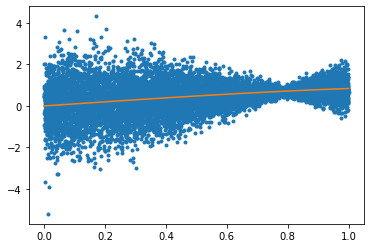

In [11]:
plt.plot(x,y,'.',x,mean_curve(x),'-')

In [40]:
class Net(nn.Module):
    def __init__(self, width, depth, ANN_type='MSE'):
        super().__init__()
        
        blocks = []
        blocks.extend([nn.Linear(1,width), nn.ReLU()])
        for j in range(depth-2):
            blocks.extend([nn.Linear(width,width), nn.ReLU()])
        
        self.ANN_type = ANN_type
        if ANN_type == 'MSE':
            blocks.append(nn.Linear(width,1))
        elif ANN_type == 'Gauss':
            blocks.append(nn.Linear(width,2))
        
        self.my_net = nn.Sequential(*blocks)
    
    def forward(self,x):
        x = self.my_net(x)
        if self.ANN_type == 'MSE':
            return x
        if self.ANN_type == 'Gauss':
            xx = torch.zeros_like(x)
            xx[:,0] = x[:,0]
            xx[:,1] = nn.functional.softplus(x[:,1]) 
            return xx

In [30]:
def minibatch(net, x, y, batch_size=64):
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    batches = x.shape[0] // batch_size
    if (batches * batch_size < x.shape[0]):
        batches += 1
    for batch in range(batches):
        idxx = idx[batch*batch_size:(batch+1)*batch_size]
        xx = x[idxx]
        yy = y[idxx]
        yield xx,yy

In [31]:
def train(net, x, y, lr=0.001, num_epochs=100, batch_size=64):    
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    criterion = nn.MSELoss()
    
    net.loss_history = {'mse': [], 'custom_mse': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_weight = 0.
        for xx, yy in minibatch(net, x, y, batch_size):
            optimizer.zero_grad()
            yhat = net.forward(xx)
            loss = criterion(yhat, yy)
            loss.backward()
            optimizer.step()
            
            nb = xx.shape[0]
            epoch_loss += nb * loss.item()
            epoch_weight += nb
        net.loss_history['mse'].append(epoch_loss/epoch_weight)
        net.loss_history['custom_mse'].append(custom_mse(net,x,y).item())
        scheduler.step()
        if epoch % 10 == 0:
            print(f"epoch = {epoch}, numpoints = {epoch_weight}, MSE = {epoch_loss/epoch_weight}")

In [32]:
def train_probabilistic(net, x, y, lr=0.001, num_epochs=100, batch_size=64):    
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    criterion = nn.GaussianNLLLoss()
    
    net.loss_history = {'gauss': [], 'custom_mse': [], 'custom_gauss': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_weight = 0.
        for xx, yy in minibatch(net, x, y, batch_size):
            optimizer.zero_grad()
            yhat = net.forward(xx)
            loss = criterion(yhat[:,0:1], yy, yhat[:,1:2])
            loss.backward()
            optimizer.step()
            
            nb = xx.shape[0]
            epoch_loss += nb * loss.item()
            epoch_weight += nb
        net.loss_history['gauss'].append(epoch_loss/epoch_weight)
        net.loss_history['custom_mse'].append(custom_mse(net,x,y).item())
        net.loss_history['custom_gauss'].append(custom_gauss(net,x,y).item())
        scheduler.step()
        if epoch % 10 == 0:
            print(f"epoch = {epoch}, numpoints = {epoch_weight}, Gaussian Loss = {epoch_loss/epoch_weight}")

In [73]:
net = Net(100,10)

In [74]:
train(net, x, y, lr = 0.001, num_epochs=30, batch_size=64)

epoch = 0, numpoints = 10000.0, MSE = 0.5627762744426728
epoch = 10, numpoints = 10000.0, MSE = 0.5313491436958313
epoch = 20, numpoints = 10000.0, MSE = 0.5295318470954895


Text(0.5, 1.0, 'MSE')

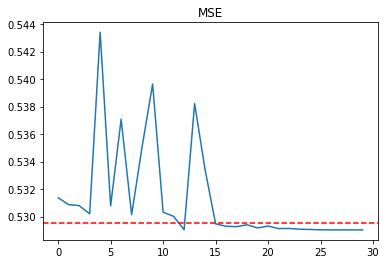

In [75]:
plt.plot(net.loss_history['custom_mse'])
plt.axhline(y=MSE_min,linestyle='--',color='r')
plt.title('MSE')

In [76]:
with torch.no_grad():
    yhat = np.array(net.forward(x))

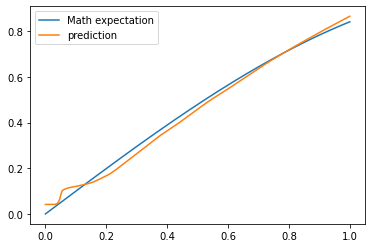

In [77]:
plt.plot(x,mean_curve(x),'-',x,yhat)
plt.legend(['Math expectation', 'prediction'])

In [78]:
pnet = Net(100,10,ANN_type='Gauss')

In [79]:
train_probabilistic(pnet, x, y, lr = 0.001, num_epochs=100, batch_size=64)

epoch = 0, numpoints = 10000.0, Gaussian Loss = 0.12454378697276115
epoch = 10, numpoints = 10000.0, Gaussian Loss = -0.07374756964445114
epoch = 20, numpoints = 10000.0, Gaussian Loss = -0.09814928897023201
epoch = 30, numpoints = 10000.0, Gaussian Loss = -0.10443328174948692
epoch = 40, numpoints = 10000.0, Gaussian Loss = -0.10447859098315239
epoch = 50, numpoints = 10000.0, Gaussian Loss = -0.11268270454406738
epoch = 60, numpoints = 10000.0, Gaussian Loss = -0.11460092387199401
epoch = 70, numpoints = 10000.0, Gaussian Loss = -0.11451998053491115
epoch = 80, numpoints = 10000.0, Gaussian Loss = -0.11624777063131332
epoch = 90, numpoints = 10000.0, Gaussian Loss = -0.11644557362794876


In [80]:
with torch.no_grad():
    yhat = pnet.forward(x)

In [81]:
criterion = nn.GaussianNLLLoss()
print('Custom and built-in Gauss losses:', custom_gauss(pnet,x,y) - criterion(yhat[:,0:1], y, yhat[:,1:2]))

Custom and built-in Gauss losses: tensor(0.)


Text(0.5, 1.0, 'Custom Gauss')

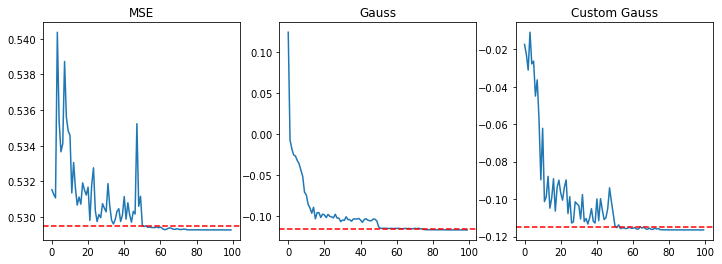

In [82]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(pnet.loss_history['custom_mse'])
plt.axhline(y=MSE_min,linestyle='--',color='r')
plt.title('MSE')
plt.subplot(132)
plt.plot(pnet.loss_history['gauss'])
plt.axhline(y=Gauss_min,linestyle='--',color='r')
plt.title('Gauss')
plt.subplot(133)
plt.plot(pnet.loss_history['custom_gauss'])
plt.axhline(y=Gauss_min,linestyle='--',color='r')
plt.title('Custom Gauss')


Text(0.5, 1.0, 'targets')

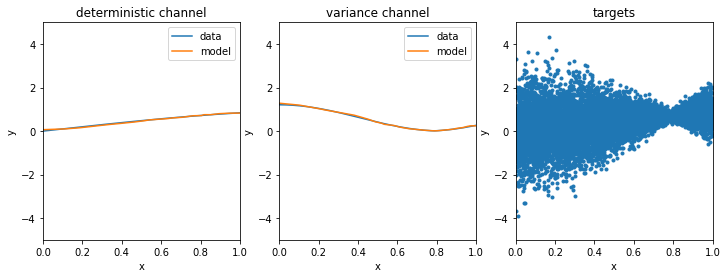

In [99]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(x,mean_curve(x),x,yhat[:,0])
plt.legend(['data', 'model'])
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0,1])
plt.ylim([-5,5])
plt.title('deterministic channel')
plt.subplot(132)
plt.plot(x,var_curve(x),x,yhat[:,1])
plt.legend(['data', 'model'])
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0,1])
plt.ylim([-5,5])
plt.title('variance channel')
plt.subplot(133)
plt.plot(x,y,'.')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0,1])
plt.ylim([-5,5])
plt.title('targets')

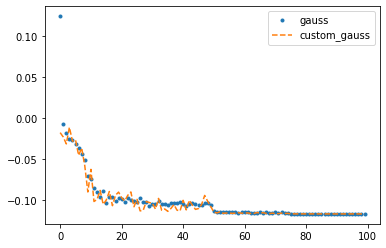

In [91]:
plt.plot(pnet.loss_history['gauss'],'.')
plt.plot(pnet.loss_history['custom_gauss'],'--')
plt.legend(['gauss', 'custom_gauss'])